# EDA completo (DermaMNIST + PathMNIST)

Este notebook realiza un análisis exploratorio de datos (EDA) para **DermaMNIST** (dataset objetivo) y **PathMNIST** (dataset control).

Incluye:
- Verificación de rutas del repositorio
- Carga y validación de archivos `.npz`
- Visualización de muestras
- Distribución de clases, porcentajes y pesos por clase
- Estadística global de intensidades
- Histogramas comparativos
- Métricas de complejidad visual: contraste (std) y entropía
- Resúmenes finales para conectar con el pipeline de entrenamiento


In [1]:
# CELDA 1
# Qué hace: importa librerías para rutas, datos y visualización.
# Para qué: poder cargar los datasets, analizarlos y graficar resultados.

from pathlib import Path                 # Para manejar rutas de forma segura (Windows/Linux)
import numpy as np                       # Para arreglos numéricos (imágenes y etiquetas)
import pandas as pd                      # Para tablas y conteos por clase
import matplotlib.pyplot as plt          # Para gráficas base
import seaborn as sns                    # Para gráficas rápidas (barras, etc.)
from PIL import Image                    # Para reescalar imágenes sin depender de OpenCV

import math                              # Para funciones matemáticas básicas (fallback de entropía)


In [2]:
# CELDA 2
# Qué hace: define la ruta raíz del repositorio y construye las rutas de los archivos .npz.
# Para qué: evitar que el notebook busque en Documents/OneDrive y asegurar que siempre apunte al repo real.

REPO_DIR = Path(r"C:\\Proyecto_integrador")            # Ruta fija a la carpeta raíz del proyecto
DATASETS_DIR = REPO_DIR / "assets" / "datasets"       # Carpeta donde están los datasets

DERMA_NPZ = DATASETS_DIR / "dermamnist.npz"             # Archivo DermaMNIST (objetivo)
PATH_NPZ = DATASETS_DIR / "pathmnist.npz"               # Archivo PathMNIST (control)

print("Raíz del repo:", REPO_DIR)                       # Confirmar la raíz usada
print("Carpeta datasets:", DATASETS_DIR)                # Confirmar la carpeta datasets

print("DERMA_NPZ:", DERMA_NPZ)                          # Mostrar ruta completa de DermaMNIST
print("¿Existe dermamnist?", DERMA_NPZ.exists())        # Validar que el archivo existe

print("PATH_NPZ:", PATH_NPZ)                            # Mostrar ruta completa de PathMNIST
print("¿Existe pathmnist?", PATH_NPZ.exists())          # Validar que el archivo existe


Raíz del repo: C:\Proyecto_integrador
Carpeta datasets: C:\Proyecto_integrador\assets\datasets
DERMA_NPZ: C:\Proyecto_integrador\assets\datasets\dermamnist.npz
¿Existe dermamnist? True
PATH_NPZ: C:\Proyecto_integrador\assets\datasets\pathmnist.npz
¿Existe pathmnist? True


In [3]:
# CELDA 3
# Qué hace: define una función para cargar un dataset .npz y validar estructura básica.
# Para qué: centralizar la carga y detectar errores temprano (archivo faltante, claves faltantes, etc.).

def cargar_y_validar_dataset(ruta_npz, nombre="dataset"):          # Función para cargar y validar un .npz
    if not ruta_npz.exists():                                       # Verificar que el archivo exista
        raise FileNotFoundError(f"No se encontró {nombre}: {ruta_npz}")  # Lanzar error si falta

    data = np.load(ruta_npz)                                        # Cargar el archivo .npz
    claves = list(data.keys())                                      # Obtener claves internas (train/test/etc.)
    print(f"[{nombre}] Claves encontradas:", claves)               # Mostrar claves para confirmar estructura

    x_train = data["train_images"]                                # Extraer imágenes de entrenamiento
    y_train = data["train_labels"]                                # Extraer etiquetas de entrenamiento

    print(f"[{nombre}] x_train shape:", x_train.shape)             # Mostrar dimensiones de imágenes
    print(f"[{nombre}] y_train shape:", y_train.shape)             # Mostrar dimensiones de etiquetas
    print(f"[{nombre}] x_train dtype:", x_train.dtype)             # Mostrar tipo de dato (ej. uint8)
    print(f"[{nombre}] Rango (min/max):", x_train.min(), x_train.max())  # Mostrar rango de intensidades

    return x_train, y_train, data                                   # Regresar también el objeto completo


In [4]:
# CELDA 4
# Qué hace: carga PathMNIST (control) y DermaMNIST (objetivo).
# Para qué: confirmar que ambos datasets están accesibles y listos para el EDA.

x_path, y_path, data_path = cargar_y_validar_dataset(PATH_NPZ, nombre="PathMNIST")       # Cargar PathMNIST
x_derma, y_derma, data_derma = cargar_y_validar_dataset(DERMA_NPZ, nombre="DermaMNIST")  # Cargar DermaMNIST


[PathMNIST] Claves encontradas: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
[PathMNIST] x_train shape: (89996, 28, 28, 3)
[PathMNIST] y_train shape: (89996, 1)
[PathMNIST] x_train dtype: uint8
[PathMNIST] Rango (min/max): 0 255
[DermaMNIST] Claves encontradas: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
[DermaMNIST] x_train shape: (7007, 28, 28, 3)
[DermaMNIST] y_train shape: (7007, 1)
[DermaMNIST] x_train dtype: uint8
[DermaMNIST] Rango (min/max): 0 255


In [5]:
# CELDA 5
# Qué hace: define un diccionario de etiquetas para DermaMNIST.
# Para qué: facilitar interpretación en gráficas y reportes (más claro que solo números).

derma_labels = {                                 # Mapeo id -> nombre de clase (ajustar si cambia el orden)
    0: "actinic_keratoses",                      # Clase 0
    1: "basal_cell_carcinoma",                   # Clase 1
    2: "benign_keratosis_like_lesions",          # Clase 2
    3: "dermatofibroma",                         # Clase 3
    4: "melanoma",                               # Clase 4
    5: "melanocytic_nevi",                       # Clase 5
    6: "vascular_lesions"                        # Clase 6
}                                                 # Fin del diccionario


## DermaMNIST: muestras y distribución de clases

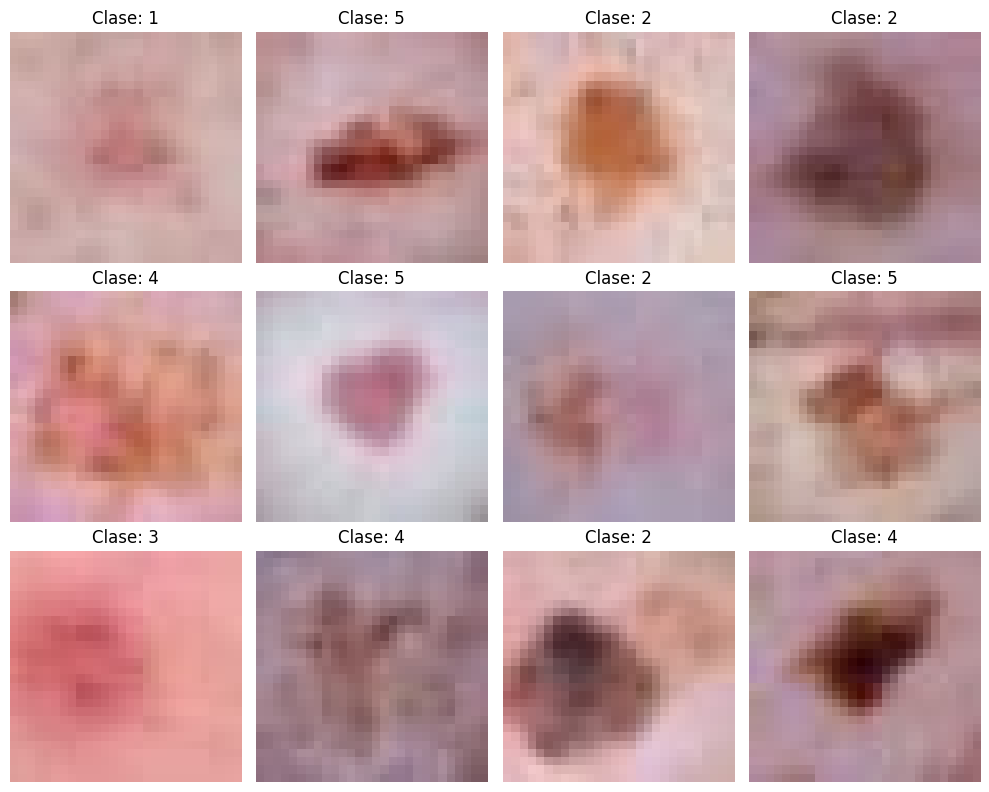

In [6]:
# CELDA 6
# Qué hace: muestra 12 imágenes aleatorias de DermaMNIST con su clase.
# Para qué: validar visualmente que el dataset se cargó correctamente y observar dificultad entre clases.

idxs = np.random.choice(len(x_derma), size=12, replace=False)       # Elegir 12 índices aleatorios sin repetir
fig, axes = plt.subplots(3, 4, figsize=(10, 8))                     # Crear cuadrícula 3x4
axes = axes.ravel()                                                 # Aplanar ejes para iterar fácil

for i, idx in enumerate(idxs):                                      # Recorrer índices seleccionados
    img = x_derma[idx]                                              # Tomar imagen
    label = int(y_derma.reshape(-1)[idx])                            # Tomar etiqueta como entero
    axes[i].imshow(img, cmap="gray")                                # Mostrar en escala de grises
    axes[i].set_title(f"Clase: {label}")                             # Título con clase
    axes[i].axis("off")                                             # Quitar ejes

plt.tight_layout()                                                  # Ajustar espacios
plt.show()                                                          # Mostrar figura


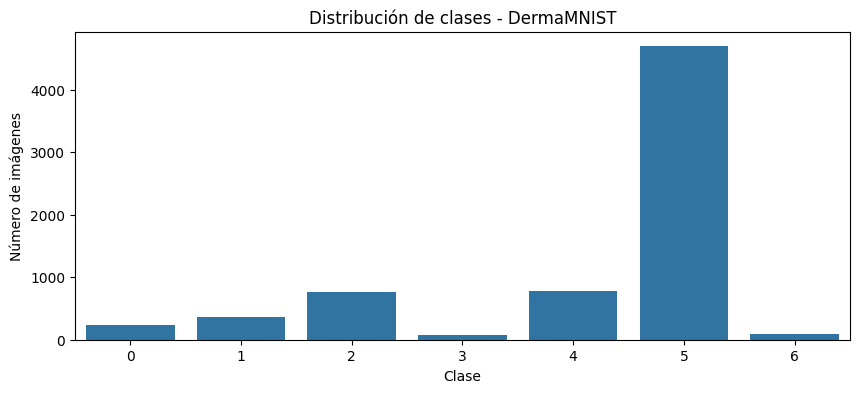

In [7]:
# CELDA 7
# Qué hace: calcula conteo por clase en DermaMNIST y lo grafica.
# Para qué: detectar desbalance de clases, que puede sesgar el entrenamiento del modelo.

etiquetas_derma_flat = y_derma.reshape(-1)                           # Aplanar etiquetas a 1D
conteo_derma = pd.Series(etiquetas_derma_flat).value_counts().sort_index()  # Contar por clase y ordenar
df_conteo_derma = conteo_derma.reset_index()                         # Pasar a DataFrame
df_conteo_derma.columns = ["clase", "conteo"]                       # Renombrar columnas

plt.figure(figsize=(10, 4))                                         # Crear figura
sns.barplot(x="clase", y="conteo", data=df_conteo_derma)            # Gráfica de barras
plt.title("Distribución de clases - DermaMNIST")                    # Título
plt.xlabel("Clase")                                                 # Eje X
plt.ylabel("Número de imágenes")                                    # Eje Y
plt.show()                                                           # Mostrar


In [8]:
# CELDA 8
# Qué hace: calcula porcentaje por clase en DermaMNIST.
# Para qué: ver proporciones reales y dimensionar el desbalance (más claro que solo conteos).

total_derma = int(df_conteo_derma["conteo"].sum())                  # Total de imágenes (train) en DermaMNIST
df_conteo_derma["porcentaje"] = (df_conteo_derma["conteo"] / total_derma) * 100  # Porcentaje por clase

df_conteo_derma                                                     # Mostrar tabla


,clase,conteo,porcentaje
0,0,228,3.253889
1,1,359,5.123448
2,2,769,10.974740
3,3,80,1.141715
4,4,779,11.117454
5,5,4693,66.975881
6,6,99,1.412873


In [9]:
# CELDA 9
# Qué hace: calcula pesos por clase (inverso a la frecuencia) para DermaMNIST.
# Para qué: usar estos pesos en el entrenamiento y reducir sesgo hacia clases mayoritarias.

frecuencias_derma = df_conteo_derma.set_index("clase")["conteo"]      # Serie con conteos por clase
num_clases_derma = int(len(frecuencias_derma))                        # Número de clases

pesos_derma = (total_derma / (num_clases_derma * frecuencias_derma)).values  # Fórmula simple de peso inverso
pesos_derma = pesos_derma.astype(np.float32)                          # Convertir a float32 (común en ML)

for i, w in enumerate(pesos_derma):                                   # Recorrer pesos por clase
    print(f"Clase {i}: peso = {w:.4f}")                               # Imprimir peso


Clase 0: peso = 4.3904
Clase 1: peso = 2.7883
Clase 2: peso = 1.3017
Clase 3: peso = 12.5125
Clase 4: peso = 1.2850
Clase 5: peso = 0.2133
Clase 6: peso = 10.1111


## DermaMNIST: reescalado y estadística global

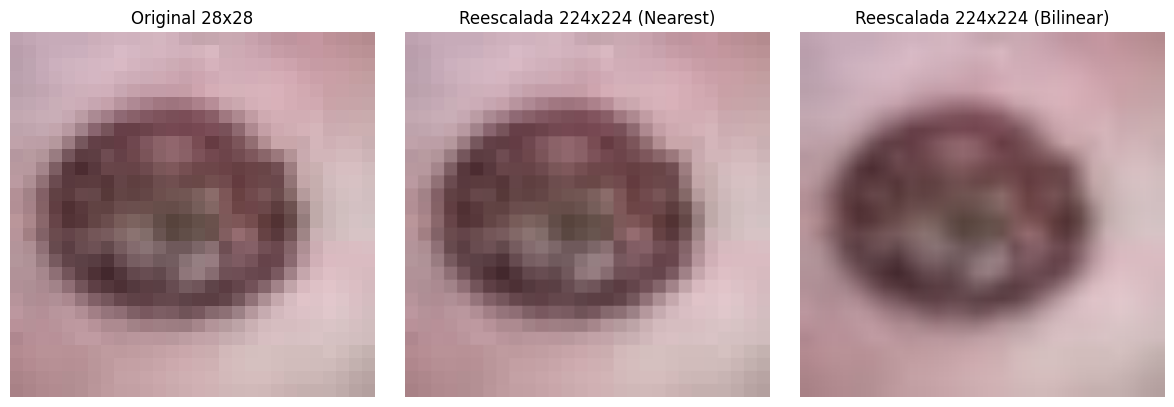

In [10]:
# CELDA 10
# Qué hace: compara una imagen 28x28 con versiones reescaladas a 224x224 (nearest vs bilinear).
# Para qué: justificar el reescalado necesario para arquitecturas tipo MobileNetV2.

idx = np.random.randint(0, len(x_derma))                              # Elegir índice aleatorio
img = x_derma[idx]                                                    # Tomar imagen original (28x28)

img_pil = Image.fromarray(img)                                        # Convertir a PIL
img_nn = img_pil.resize((224, 224), resample=Image.NEAREST)           # Reescalado nearest (pixelado)
img_bl = img_pil.resize((224, 224), resample=Image.BILINEAR)          # Reescalado bilinear (suavizado)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))                       # Crear 3 paneles

axes[0].imshow(img, cmap="gray")                                      # Mostrar original
axes[0].set_title("Original 28x28")                                   # Título
axes[0].axis("off")                                                   # Sin ejes

axes[1].imshow(np.array(img_nn), cmap="gray")                         # Mostrar nearest
axes[1].set_title("Reescalada 224x224 (Nearest)")                     # Título
axes[1].axis("off")                                                   # Sin ejes

axes[2].imshow(np.array(img_bl), cmap="gray")                         # Mostrar bilinear
axes[2].set_title("Reescalada 224x224 (Bilinear)")                    # Título
axes[2].axis("off")                                                   # Sin ejes

plt.tight_layout()                                                    # Ajustar espacios
plt.show()                                                            # Mostrar


In [11]:
# CELDA 11
# Qué hace: calcula media, desviación estándar, mínimo y máximo de intensidades en DermaMNIST.
# Para qué: justificar normalización/estandarización y detectar valores fuera de rango.

media_derma = float(np.mean(x_derma))                                  # Media global
std_derma = float(np.std(x_derma))                                     # Desviación estándar global
min_derma = int(np.min(x_derma))                                       # Mínimo
max_derma = int(np.max(x_derma))                                       # Máximo

print("---- DermaMNIST ----")                                         # Encabezado
print("Media:", media_derma)                                          # Mostrar media
print("STD:", std_derma)                                              # Mostrar std
print("Min:", min_derma)                                              # Mostrar min
print("Max:", max_derma)                                              # Mostrar max


---- DermaMNIST ----
Media: 158.32006671656816
STD: 46.95351927848184
Min: 0
Max: 255


In [12]:
# CELDA 12
# Qué hace: crea un resumen de hallazgos para DermaMNIST.
# Para qué: cerrar el bloque DermaMNIST y conectar con el pipeline de entrenamiento.

hallazgos_derma = {                                                    # Diccionario de resumen
    "total_imagenes_train": int(total_derma),                          # Total de imágenes train
    "num_clases": int(num_clases_derma),                               # Número de clases
    "resolucion": str(x_derma.shape[1:3]),                             # Resolución original
    "rango_pixeles": (int(min_derma), int(max_derma)),                 # Rango de intensidades
    "nota": "Se observa desbalance; se recomienda usar pesos por clase y métricas sensibles."  # Nota breve
}                                                                      # Fin del diccionario

hallazgos_derma                                                        # Mostrar


{'total_imagenes_train': 7007,
 'num_clases': 7,
 'resolucion': '(28, 28)',
 'rango_pixeles': (0, 255),
 'nota': 'Se observa desbalance; se recomienda usar pesos por clase y métricas sensibles.'}

## PathMNIST: muestras y distribución de clases

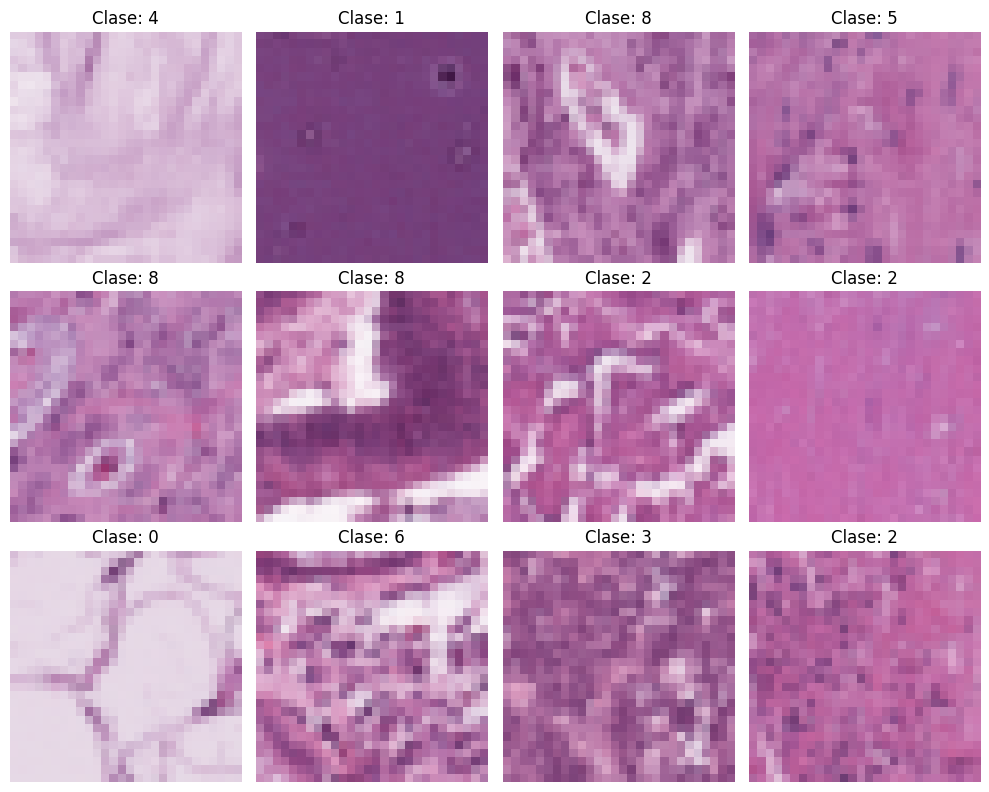

In [13]:
# CELDA 13
# Qué hace: muestra 12 imágenes aleatorias de PathMNIST con su clase.
# Para qué: validar visualmente el dataset control y compararlo con DermaMNIST.

idxs = np.random.choice(len(x_path), size=12, replace=False)            # Elegir 12 índices aleatorios
fig, axes = plt.subplots(3, 4, figsize=(10, 8))                         # Crear cuadrícula 3x4
axes = axes.ravel()                                                     # Aplanar ejes

for i, idx in enumerate(idxs):                                          # Recorrer índices
    img = x_path[idx]                                                   # Tomar imagen
    label = int(y_path.reshape(-1)[idx])                                # Tomar etiqueta como entero
    axes[i].imshow(img, cmap="gray")                                   # Mostrar imagen
    axes[i].set_title(f"Clase: {label}")                                # Título con clase
    axes[i].axis("off")                                                # Quitar ejes

plt.tight_layout()                                                      # Ajustar espacios
plt.show()                                                              # Mostrar


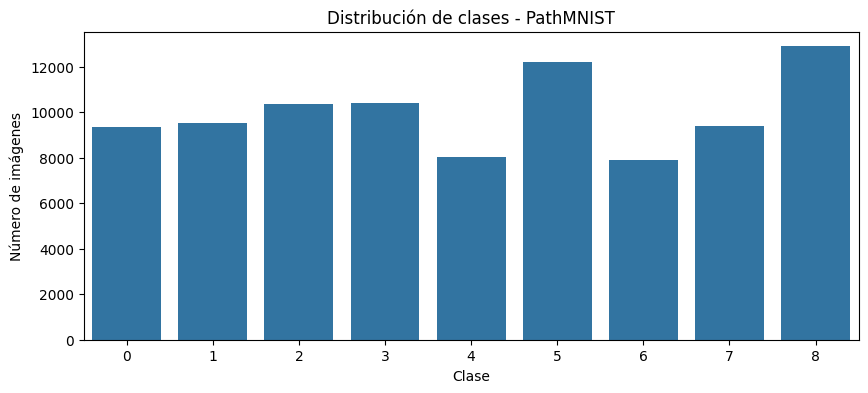

In [14]:
# CELDA 14
# Qué hace: calcula conteo por clase en PathMNIST y lo grafica.
# Para qué: identificar desbalance en el dataset control y compararlo con el objetivo.

etiquetas_path_flat = y_path.reshape(-1)                                # Aplanar etiquetas
conteo_path = pd.Series(etiquetas_path_flat).value_counts().sort_index()  # Contar por clase
df_conteo_path = conteo_path.reset_index()                              # Pasar a DataFrame
df_conteo_path.columns = ["clase", "conteo"]                           # Renombrar columnas

plt.figure(figsize=(10, 4))                                             # Crear figura
sns.barplot(x="clase", y="conteo", data=df_conteo_path)                # Barras
plt.title("Distribución de clases - PathMNIST")                        # Título
plt.xlabel("Clase")                                                     # Eje X
plt.ylabel("Número de imágenes")                                        # Eje Y
plt.show()                                                               # Mostrar


In [15]:
# CELDA 15
# Qué hace: calcula porcentaje por clase en PathMNIST.
# Para qué: comparar proporciones con DermaMNIST y evaluar diferencias en balance.

total_path = int(df_conteo_path["conteo"].sum())                        # Total de imágenes (train) en PathMNIST
df_conteo_path["porcentaje"] = (df_conteo_path["conteo"] / total_path) * 100  # Porcentaje por clase

df_conteo_path                                                           # Mostrar tabla


,clase,conteo,porcentaje
0,0,9366,10.407129
1,1,9509,10.566025
2,2,10360,11.511623
3,3,10401,11.557180
4,4,8006,8.895951
5,5,12182,13.536157
6,6,7886,8.762612
7,7,9401,10.446020
8,8,12885,14.317303


In [16]:
# CELDA 16
# Qué hace: compara estructura básica entre DermaMNIST y PathMNIST.
# Para qué: confirmar similitudes (resolución) y diferencias (tamaño y clases) para sustento metodológico.

print("---- DermaMNIST ----")                                            # Encabezado Derma
print("Total imágenes (train):", len(x_derma))                           # Tamaño de Derma
print("Resolución:", x_derma.shape[1:3])                                 # Resolución Derma
print("Número de clases:", len(df_conteo_derma))                         # Clases Derma

print("\n---- PathMNIST ----")                                          # Encabezado Path
print("Total imágenes (train):", len(x_path))                            # Tamaño de Path
print("Resolución:", x_path.shape[1:3])                                  # Resolución Path
print("Número de clases:", len(df_conteo_path))                          # Clases Path


---- DermaMNIST ----
Total imágenes (train): 7007
Resolución: (28, 28)
Número de clases: 7

---- PathMNIST ----
Total imágenes (train): 89996
Resolución: (28, 28)
Número de clases: 9


## Comparación global: estadísticas e histogramas

In [17]:
# CELDA 17
# Qué hace: calcula estadísticas básicas de intensidad para PathMNIST.
# Para qué: comparar escala y dispersión de intensidades con DermaMNIST.

media_path = float(np.mean(x_path))                                       # Media global
std_path = float(np.std(x_path))                                          # Desviación estándar global
min_path = int(np.min(x_path))                                            # Mínimo
max_path = int(np.max(x_path))                                            # Máximo

print("---- PathMNIST ----")                                             # Encabezado
print("Media:", media_path)                                              # Mostrar media
print("STD:", std_path)                                                  # Mostrar std
print("Min:", min_path)                                                  # Mostrar min
print("Max:", max_path)                                                  # Mostrar max


---- PathMNIST ----
Media: 168.24526370200732
STD: 43.36160886906823
Min: 0
Max: 255


In [18]:
# CELDA 18
# Qué hace: imprime estadísticas lado a lado (Derma vs Path).
# Para qué: facilitar comparación directa para el reporte de tesis.

print("========== COMPARACIÓN GLOBAL ==========")                        # Encabezado

print("\nDermaMNIST")                                                    # Subtítulo
print("Media:", media_derma)                                              # Media Derma
print("STD:", std_derma)                                                  # STD Derma

print("\nPathMNIST")                                                     # Subtítulo
print("Media:", media_path)                                               # Media Path
print("STD:", std_path)                                                   # STD Path


========== COMPARACIÓN GLOBAL ==========

DermaMNIST
Media: 158.32006671656816
STD: 46.95351927848184

PathMNIST
Media: 168.24526370200732
STD: 43.36160886906823


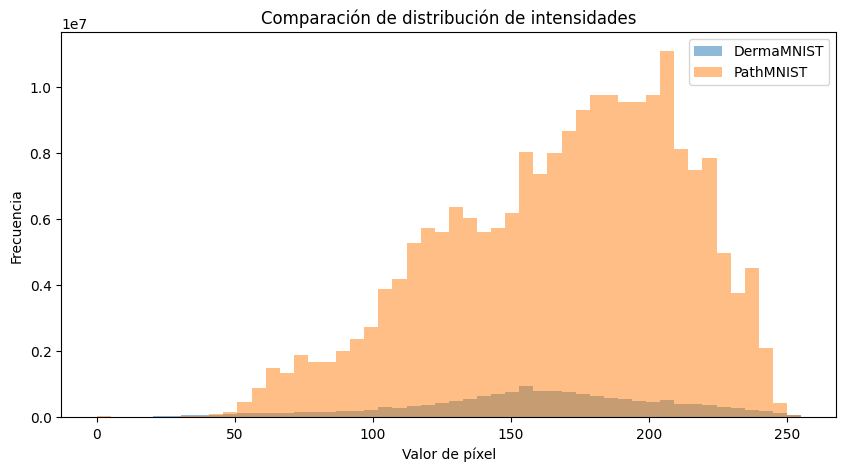

In [19]:
# CELDA 19
# Qué hace: grafica histogramas de intensidades para DermaMNIST y PathMNIST.
# Para qué: ver si las distribuciones de píxeles son similares o tienen sesgos distintos.

plt.figure(figsize=(10, 5))                                               # Crear figura

plt.hist(x_derma.flatten(), bins=50, alpha=0.5, label="DermaMNIST")       # Histograma Derma
plt.hist(x_path.flatten(), bins=50, alpha=0.5, label="PathMNIST")         # Histograma Path

plt.title("Comparación de distribución de intensidades")                  # Título
plt.xlabel("Valor de píxel")                                              # Eje X
plt.ylabel("Frecuencia")                                                  # Eje Y
plt.legend()                                                               # Leyenda
plt.show()                                                                 # Mostrar


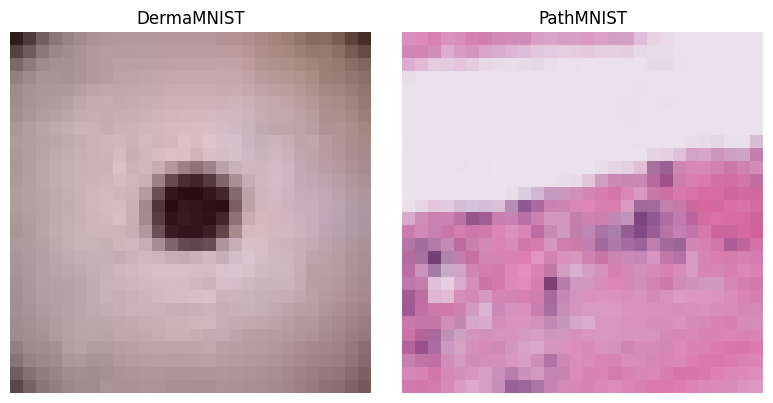

In [20]:
# CELDA 20
# Qué hace: muestra una imagen aleatoria de DermaMNIST y una de PathMNIST lado a lado.
# Para qué: comparar visualmente complejidad, textura y patrón general entre datasets.

idx_derma = np.random.randint(0, len(x_derma))                             # Índice aleatorio Derma
idx_path = np.random.randint(0, len(x_path))                               # Índice aleatorio Path

fig, axes = plt.subplots(1, 2, figsize=(8, 4))                             # Crear 2 paneles

axes[0].imshow(x_derma[idx_derma], cmap="gray")                           # Mostrar Derma
axes[0].set_title("DermaMNIST")                                          # Título Derma
axes[0].axis("off")                                                      # Sin ejes

axes[1].imshow(x_path[idx_path], cmap="gray")                             # Mostrar Path
axes[1].set_title("PathMNIST")                                           # Título Path
axes[1].axis("off")                                                      # Sin ejes

plt.tight_layout()                                                        # Ajustar espacios
plt.show()                                                                # Mostrar


## Complejidad visual: contraste y entropía

In [21]:
# CELDA 21
# Qué hace: calcula el contraste por imagen usando la desviación estándar (std) por imagen.
# Para qué: medir variabilidad interna de intensidades, lo cual sugiere complejidad visual.

contraste_derma = []                                                      # Lista para contraste de Derma
contraste_path = []                                                       # Lista para contraste de Path

for img in x_derma:                                                       # Recorrer imágenes Derma
    contraste_derma.append(np.std(img))                                   # Guardar std de cada imagen

for img in x_path:                                                        # Recorrer imágenes Path
    contraste_path.append(np.std(img))                                    # Guardar std de cada imagen

contraste_derma = np.array(contraste_derma)                               # Convertir a numpy array
contraste_path = np.array(contraste_path)                                 # Convertir a numpy array

print("Contraste promedio DermaMNIST:", float(contraste_derma.mean()))   # Promedio Derma
print("Contraste promedio PathMNIST:", float(contraste_path.mean()))     # Promedio Path


Contraste promedio DermaMNIST: 40.58191151985158
Contraste promedio PathMNIST: 33.1682237494293


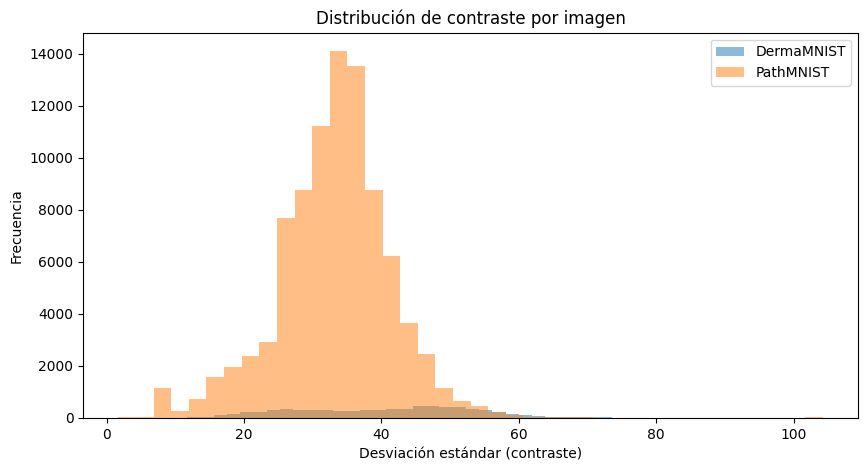

In [22]:
# CELDA 22
# Qué hace: grafica histogramas de contraste por imagen (Derma vs Path).
# Para qué: ver si un dataset tiene mayor variabilidad (más complejo) que el otro.

plt.figure(figsize=(10, 5))                                               # Crear figura

plt.hist(contraste_derma, bins=40, alpha=0.5, label="DermaMNIST")         # Histograma Derma
plt.hist(contraste_path, bins=40, alpha=0.5, label="PathMNIST")           # Histograma Path

plt.title("Distribución de contraste por imagen")                        # Título
plt.xlabel("Desviación estándar (contraste)")                            # Eje X
plt.ylabel("Frecuencia")                                                 # Eje Y
plt.legend()                                                               # Leyenda
plt.show()                                                                 # Mostrar


In [23]:
# CELDA 23
# Qué hace: define funciones para calcular entropía por imagen.
# Para qué: medir "cantidad de información" en la imagen (complejidad) y comparar Derma vs Path.

def entropia_desde_histograma(hist):                                       # Entropía desde histograma normalizado
    hist = np.asarray(hist, dtype=np.float64)                              # Asegurar tipo flotante
    hist = hist + 1e-12                                                    # Evitar log(0)
    hist = hist / hist.sum()                                               # Normalizar (suma 1)
    return float(-(hist * np.log(hist)).sum())                             # Entropía Shannon

def calcular_entropia(img):                                                # Función para una imagen
    valores = img.flatten()                                                # Aplanar píxeles
    hist, _ = np.histogram(valores, bins=256, range=(0, 255), density=False)  # Histograma (conteos)
    return entropia_desde_histograma(hist)                                 # Calcular entropía


In [24]:
# CELDA 24
# Qué hace: calcula entropía por imagen en DermaMNIST y PathMNIST y compara promedios.
# Para qué: estimar complejidad informacional y sustentar diferencias entre datasets.

entropia_derma = []                                                        # Lista para entropías Derma
entropia_path = []                                                         # Lista para entropías Path

for img in x_derma:                                                        # Recorrer Derma
    entropia_derma.append(calcular_entropia(img))                          # Guardar entropía

for img in x_path:                                                         # Recorrer Path
    entropia_path.append(calcular_entropia(img))                           # Guardar entropía

entropia_derma = np.array(entropia_derma, dtype=np.float64)                # Convertir a numpy
entropia_path = np.array(entropia_path, dtype=np.float64)                  # Convertir a numpy

print("Entropía promedio DermaMNIST:", float(entropia_derma.mean()))      # Promedio Derma
print("Entropía promedio PathMNIST:", float(entropia_path.mean()))        # Promedio Path


Entropía promedio DermaMNIST: 4.679864905240581
Entropía promedio PathMNIST: 4.449476887315415


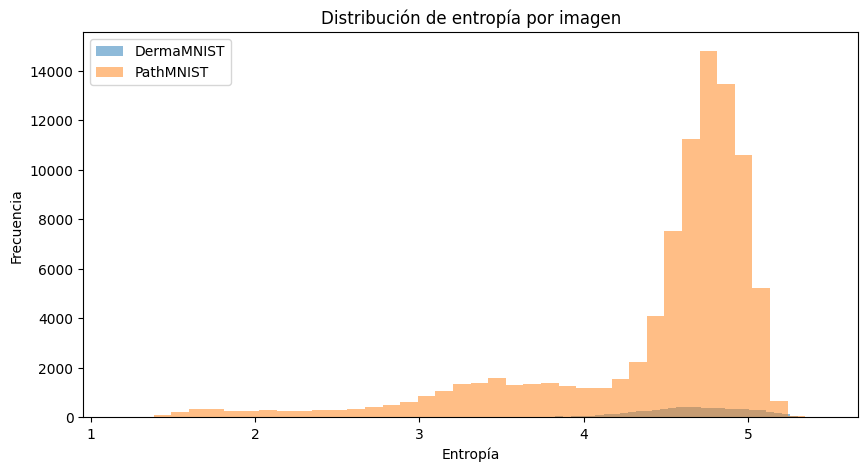

In [25]:
# CELDA 25
# Qué hace: grafica histogramas de entropía por imagen (Derma vs Path).
# Para qué: comparar distribución de complejidad informacional entre datasets.

plt.figure(figsize=(10, 5))                                               # Crear figura

plt.hist(entropia_derma, bins=40, alpha=0.5, label="DermaMNIST")          # Histograma Derma
plt.hist(entropia_path, bins=40, alpha=0.5, label="PathMNIST")            # Histograma Path

plt.title("Distribución de entropía por imagen")                         # Título
plt.xlabel("Entropía")                                                   # Eje X
plt.ylabel("Frecuencia")                                                 # Eje Y
plt.legend()                                                               # Leyenda
plt.show()                                                                 # Mostrar


## Resumen comparativo final (para tesis y para conectar con el pipeline)

In [26]:
# CELDA 26
# Qué hace: resume métricas comparativas clave en un solo diccionario.
# Para qué: dejar evidencia cuantitativa lista para el documento (estado del dataset, complejidad y balance).

resumen_comparativo = {                                                    # Diccionario final
    "Repo": str(REPO_DIR),                                                # Ruta del repo usada
    "Datasets": str(DATASETS_DIR),                                        # Carpeta datasets

    "Derma_train_total": int(total_derma),                                # Total train Derma
    "Derma_num_clases": int(num_clases_derma),                             # Clases Derma
    "Derma_resolucion": str(x_derma.shape[1:3]),                           # Resolución Derma
    "Derma_media": float(media_derma),                                     # Media Derma
    "Derma_std": float(std_derma),                                         # STD Derma
    "Derma_contraste_prom": float(contraste_derma.mean()),                 # Contraste promedio Derma
    "Derma_entropia_prom": float(entropia_derma.mean()),                   # Entropía promedio Derma

    "Path_train_total": int(total_path),                                  # Total train Path
    "Path_num_clases": int(len(df_conteo_path)),                           # Clases Path
    "Path_resolucion": str(x_path.shape[1:3]),                             # Resolución Path
    "Path_media": float(media_path),                                       # Media Path
    "Path_std": float(std_path),                                           # STD Path
    "Path_contraste_prom": float(contraste_path.mean()),                   # Contraste promedio Path
    "Path_entropia_prom": float(entropia_path.mean()),                     # Entropía promedio Path

    "Siguiente_paso": "Entrenar modelo ligero (MobileNetV2), evaluar con métricas clínicas y cuantizar para Edge."  # Conclusión
}                                                                          # Fin

resumen_comparativo                                                        # Mostrar


{'Repo': 'C:\\Proyecto_integrador',
 'Datasets': 'C:\\Proyecto_integrador\\assets\\datasets',
 'Derma_train_total': 7007,
 'Derma_num_clases': 7,
 'Derma_resolucion': '(28, 28)',
 'Derma_media': 158.32006671656816,
 'Derma_std': 46.95351927848184,
 'Derma_contraste_prom': 40.58191151985158,
 'Derma_entropia_prom': 4.679864905240581,
 'Path_train_total': 89996,
 'Path_num_clases': 9,
 'Path_resolucion': '(28, 28)',
 'Path_media': 168.24526370200732,
 'Path_std': 43.36160886906823,
 'Path_contraste_prom': 33.1682237494293,
 'Path_entropia_prom': 4.449476887315415,
 'Siguiente_paso': 'Entrenar modelo ligero (MobileNetV2), evaluar con métricas clínicas y cuantizar para Edge.'}

## Nota final (para redacción de tesis)

- Si **DermaMNIST** muestra mayor desbalance, se justifica usar `class weights` y métricas como sensibilidad/recall por clase.
- Si la **entropía** o el **contraste** son mayores, se puede argumentar que el dataset tiene mayor complejidad visual.
- El reescalado 28×28 → 224×224 se justifica para compatibilidad con arquitecturas móviles (MobileNetV2).
